# Semantic Chunking
In this notebook I will try an semantic chunking startegy developed by Greg. [Link](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/8a30b5710b3dd99ef2239fb60c7b54bc38d3613d/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb)

In [2]:
with open('../fiqa_dataset/corpus.txt') as file:
    corpus = file.read()


In [3]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', corpus)
print (f"{len(single_sentences_list)} sentences were found")


399187 sentences were found


In [6]:
small_single_sentences_list = single_sentences_list[:1000]
print (f"{len(small_single_sentences_list)} sentences were found")

sentences = [{'sentence': x, 'index': i} for i, x in enumerate(small_single_sentences_list)]
sentences[:3]


1000 sentences were found


[{'sentence': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that.",
  'index': 0},
 {'sentence': "Training workers is not their job - they're building software.",
  'index': 1},
 {'sentence': 'Perhaps educational systems in the U.S.', 'index': 2}]

Create dictionary to store additional information later

In [3]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that.",
  'index': 0},
 {'sentence': "Training workers is not their job - they're building software.",
  'index': 1},
 {'sentence': 'Perhaps educational systems in the U.S.', 'index': 2}]

Now we want to combine the senteces with the one before and after. Therefor we use butter_size=1

In [7]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [8]:
sentences[:3]

[{'sentence': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that.",
  'index': 0,
  'combined_sentence': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software."},
 {'sentence': "Training workers is not their job - they're building software.",
  'index': 1,
  'combined_sentence': "I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to do that. Training workers is not their job - they're building software. Perhaps educational systems in the U.S."},
 {'sentence': 'Perhaps educational systems in the U.S.',
  'index': 2,
  'combined_sentence': "Training workers is not their job - they're building software. Perhaps educational systems in the U.S. (or their students) should worry a little about getting marketable skills in exchange for their massive investment in education

We want to create embeddings for each batch (3 sentences) and add them to the corresponding dictionary index.

In [9]:
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import logger

load_dotenv()

oaiembeds = OpenAIEmbeddings(model='text-embedding-3-small', api_key=os.environ.get('OPENAI_API_KEY'))

In [10]:
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [12]:
distances, sentences = calculate_cosine_distances(sentences)

In [17]:
distances[:50]

[0.07133265430168634,
 0.274253684391935,
 0.3650982875210518,
 0.14073606514786552,
 0.17122389461812104,
 0.23305929465355102,
 0.2447662113853296,
 0.32636535752206974,
 0.1054397558171355,
 0.13284176530789293,
 0.45512135430770306,
 0.1152314695832013,
 0.26737779006252027,
 0.12568855963078462,
 0.47944366150988604,
 0.17704427546592305,
 0.21992440817905223,
 0.5353045404717303,
 0.311318839127124,
 0.140737065755566,
 0.2086478305399222,
 0.4079017893727015,
 0.5291640545117031,
 0.029095895769267965,
 0.14919965573065896,
 0.39876960890895197,
 0.14933377878353282,
 0.12878203482328088,
 0.22773780325917947,
 0.1956684205392185,
 0.10860954594161831,
 0.13562301214722683,
 0.2891299803314855,
 0.06611665039616921,
 0.09307714454158811,
 0.48080579794768896,
 0.12493040387685017,
 0.37466581525596176,
 0.38107199709135053,
 0.16794595299349968,
 0.4479413096155843,
 0.15688688332156553,
 0.36031900830052543,
 0.0870195199471614,
 0.14331500873223657,
 0.48879732456379976,
 0.04

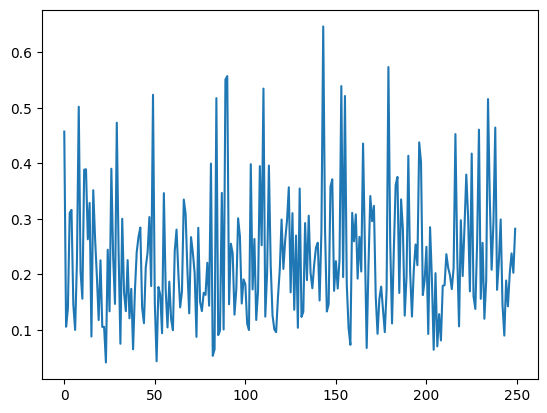

In [22]:
import matplotlib.pyplot as plt

plt.plot(distances[250:500])

In [15]:
print(len(sentences[3]['combined_sentence']) )

462


In [10]:

oaiembeds = OpenAIEmbeddings(model='text-embedding-3-small', api_key=os.environ.get('OPENAI_API_KEY'))

embeddings = oaiembeds.embed_documents(sentences[3]['combined_sentence'])

# for i, sentence in enumerate(sentences):
#     sentence['combined_sentence_embedding'] = embeddings[i]

In [26]:
print(embeddings[0])

[0.04412008573227445, 0.020497117766661594, 0.0001921859129006022, 0.005087648195471535, 0.021669312056929617, 0.0035633888164110956, -0.008465846306691982, 0.03116082860043677, -0.03513326221933786, -0.08745870984613369, 0.008677493093002038, 0.012088252570651086, -0.04014764838808296, 0.0017013096262286117, 0.014237274815260732, -0.01717590030046132, 0.027220954019657788, -0.021311140285844108, 0.017794559277685234, 0.05818641349020035, 0.0045585326266802985, 0.018266691407488492, -0.018478338193798547, -0.030411926020143656, -0.010110174589408468, -0.017810838796746283, -0.002812451994727298, 0.008905419398373141, 0.033472654417560324, -0.007529719478309487, 0.01854345999533315, -0.02697674633258043, -0.021425104369852264, -0.023899736553457517, 0.03241442607394565, -0.005295224170693727, -0.03848704058630543, 0.04014764838808296, -0.03163296073024003, 0.04548764356450108, -0.022499615957818384, 0.0027717508687681723, -0.03304936457023062, -0.004835300748863654, 0.06154019185716793,

Next, we calculate the cosine distances between sequential embedding pairs

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances_chunked(sentences, batch_size=1000):
    def get_embeddings(sentences):
        return oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

    def compute_distances(embeddings_chunk):
        distances = []
        for i in range(len(embeddings_chunk) - 1):
            embedding_current = embeddings_chunk[i]
            embedding_next = embeddings_chunk[i + 1]
            
            # Calculate cosine similarity
            similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
            
            # Convert to cosine distance
            distance = 1 - similarity

            # Append cosine distance to the list
            distances.append(distance)
        
        return distances

    total_sentences = len(sentences)
    all_distances = []

    for start_idx in range(0, total_sentences, batch_size):
        end_idx = min(start_idx + batch_size + 1, total_sentences)
        sentences_chunk = sentences[start_idx:end_idx]
        
        # Embed the current chunk
        embeddings_chunk = get_embeddings(sentences_chunk)
        
        # Compute distances for the current chunk
        distances_chunk = compute_distances(embeddings_chunk)
        all_distances.extend(distances_chunk)
        
        # Update the original sentences with distances
        for i in range(len(distances_chunk)):
            sentences[start_idx + i]['distance_to_next'] = distances_chunk[i]

    return all_distances, sentences

# Example usage:
distances, updated_sentences = calculate_cosine_distances_chunked(sentences, batch_size=1000)

KeyboardInterrupt: 